In [1]:
%cd torchspdnet_untouched 

# %cd torchspdnet

import os, sys
sys.path.append(os.getcwd())

/Users/alexa/Documents/MASTERS_DISSERTATION/Code_Base/torchspdnet_untouched


In [2]:
# Preliminaries 
import numpy as np
import pandas as pd
import time

from random import randint
import os
import shutil

from numpy import sqrt 
import torch as th
from scipy.stats import t
import sys

from datetime import datetime
from datetime import timedelta
import missingno as msno

# Enable anomaly detection
th.autograd.set_detect_anomaly(True)

import fastcluster
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

import networkx as nx
from scipy.spatial.distance import squareform

from scipy.stats import rankdata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import random
random.seed(27)

import torch.nn as nn
from torch.utils import data

import torchspdnet.nn as spdnet
from torchspdnet.optimizers import MixOptimizer

from collections import Counter

In [3]:
# Randomised beta coefficients corresponding to the Yelibi & Gebbie (2021) adaptation of the Tumminello (2007) HNFM.
def generate_beta_values(c, total_sum=1):
    beta_values = np.zeros(c)
    remaining = total_sum
    for i in range(c-1):
        beta_values[i] = remaining * np.random.uniform(0.1, 0.5)
        remaining -= beta_values[i]
    beta_values[-1] = remaining
    return beta_values

# Ensure synthetic matrices are SPD
def make_positive_definite(matrix): 
    epsilon = 1e-6  # small constant
    if np.isfinite(matrix).all() and np.all(np.linalg.eigvals(matrix) > 0):
        # The matrix is already positive definite
        return matrix
    else:
        # Regularization
        return matrix + epsilon * np.eye(matrix.shape[0])

def nearest_positive_definite(matrix):
    """ Higham's algorithm to find the nearest positive definite matrix """
    B = (matrix + matrix.T) / 2
    _, s, V = np.linalg.svd(B)
    H = np.dot(V.T, np.dot(np.diag(s), V))
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2

    if is_positive_definite(A3):
        return A3

    spacing = np.spacing(np.linalg.norm(matrix))
    identity_matrix = np.eye(matrix.shape[0])
    k = 1
    while not is_positive_definite(A3):
        min_eig_val = np.min(np.real(np.linalg.eigvals(A3)))
        A3 += identity_matrix * (-min_eig_val * k**2 + spacing)
        k += 1

    return A3

def is_positive_definite(matrix):
    """ Check if a matrix is positive definite """
    try:
        np.linalg.cholesky(matrix)
        return True
    except np.linalg.LinAlgError:
        return False

# Annualized Sharpe ratio for data labeling 
def calculate_sharpe_ratio(returns, risk_free_rate=0.0):
    excess_returns = returns - risk_free_rate
    mean_return = excess_returns.mean() * 252
    vol = excess_returns.std() * np.sqrt(252)
    sharpe = mean_return / vol
    return sharpe

def generate_timeseries_from_correlation(correlation_matrix, L):
    C = nearest_positive_definite(correlation_matrix)  # Ensure matrix is positive definite
    cholesky_decomp = np.linalg.cholesky(C)
    student_t_samples = np.random.standard_t(3, size=(correlation_matrix.shape[0], L))
    return np.dot(cholesky_decomp, student_t_samples)

def hierarchical_factor_model(N, c, L, M):
    xi = np.zeros((N, L))
    stocks_per_cluster = N // M
    stocks_per_hierarchy = stocks_per_cluster // c

    for cluster in range(M):
        eta = np.random.randn(c, L)
        epsilon = np.random.randn(stocks_per_cluster, L)
        beta_values = generate_beta_values(c)

        for k in range(c):
            start_idx = cluster * stocks_per_cluster + k * stocks_per_hierarchy
            end_idx = start_idx + stocks_per_hierarchy

            alpha_k = 1 - np.sum(beta_values[:k+1])
            for j in range(k + 1):
                xi[start_idx:end_idx, :] += beta_values[j] * eta[j, :]

            xi[start_idx:end_idx, :] += alpha_k * epsilon[(k * stocks_per_hierarchy):(k+1) * stocks_per_hierarchy, :]

    correlation_matrix = np.corrcoef(xi)
    return xi, correlation_matrix

# def perturb_correlation_matrix_to_target_mean(correlation_matrix, target_mean, tolerance=0.05, max_iterations=100):
#     """
#     Apply a random perturbation to a correlation matrix to shift the mean towards a target mean correlation.
    
#     :param correlation_matrix: The original correlation matrix to perturb.
#     :param target_mean: The target mean correlation to achieve.
#     :param tolerance: The acceptable range around the target mean.
#     :param max_iterations: The maximum number of iterations to attempt to reach the target mean.
#     :return: A perturbed correlation matrix with a mean closer to the target mean.
#     """
#     perturbed_matrix = correlation_matrix.copy()
#     for _ in range(max_iterations):
#         current_mean = np.mean(perturbed_matrix[np.triu_indices_from(perturbed_matrix, k=1)])
#         if np.abs(current_mean - target_mean) < tolerance:
#             break  # Stop if within tolerance
#         # Calculate perturbation strength
#         perturbation_strength = (target_mean - current_mean) / 2
#         # Apply perturbation
#         noise = np.random.normal(0, perturbation_strength, size=perturbed_matrix.shape)
#         noise = (noise + noise.T) / 2  # Make the noise symmetric
#         np.fill_diagonal(noise, 0)  # Do not change diagonal values
#         perturbed_matrix += noise
#         # Clamp and ensure positive definiteness
#         np.fill_diagonal(perturbed_matrix, 1)  # Reset diagonals to 1
#         #perturbed_matrix = np.clip(perturbed_matrix, -1, 1)
#         #perturbed_matrix = nearest_positive_definite(perturbed_matrix)
        
#     return perturbed_matrix

def adjust_matrix_to_target_mean(correlation_matrix, target_mean):
    """
    Directly adjust the elements of the correlation matrix to achieve a target mean for the off-diagonal elements,
    while ensuring the matrix remains positive definite.
    
    :param correlation_matrix: The original correlation matrix to adjust.
    :param target_mean: The target mean correlation for the off-diagonal elements.
    :return: An adjusted correlation matrix with the desired target mean.
    """
    n = correlation_matrix.shape[0]
    current_mean = np.mean(correlation_matrix[np.triu_indices(n, 1)])
    adjustment = target_mean - current_mean
    adjusted_matrix = correlation_matrix.copy()

    # Apply the adjustment to the off-diagonal elements
    adjusted_matrix[np.triu_indices(n, 1)] += adjustment
    adjusted_matrix[np.tril_indices(n, -1)] += adjustment

    # Ensure diagonal elements remain 1
    np.fill_diagonal(adjusted_matrix, 1)

    # Ensure the matrix is still positive definite
    adjusted_matrix = nearest_positive_definite(adjusted_matrix)

    return adjusted_matrix

def find_divisors(n):
    """ Return a list of divisors of n """
    divisors = [i for i in range(1, n + 1) if n % i == 0]
    return divisors

def select_c_and_M(N):
    """ Select values for c and M such that their product equals N """
    divisors = find_divisors(N)
    c = np.random.choice(divisors)
    M = N // c
    return c, M

# Example usage within the while loop
targets = [0.1, 0.2, 0.27]

# Constants for the mean correlations as required
mean_correlations = {
    'stressed': 0.27,
    'normal': 0.2,
    'rally': 0.1
}

# Variance values are taken from the provided image (to be extracted)
# For the purpose of this example, we'll assume some arbitrary values
variances = {
    'stressed': 0.05**2,
    'normal': 0.03**2,
    'rally': 0.01**2
}


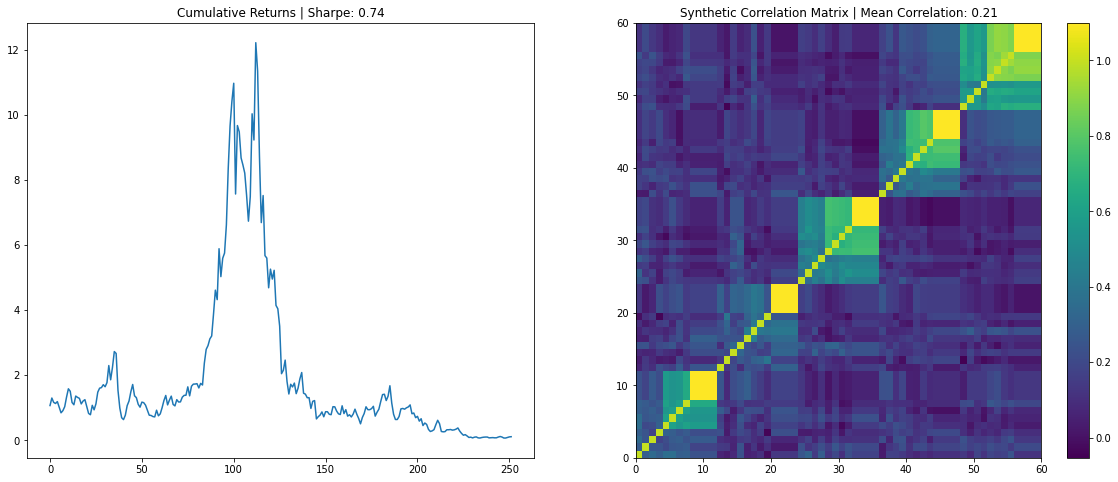

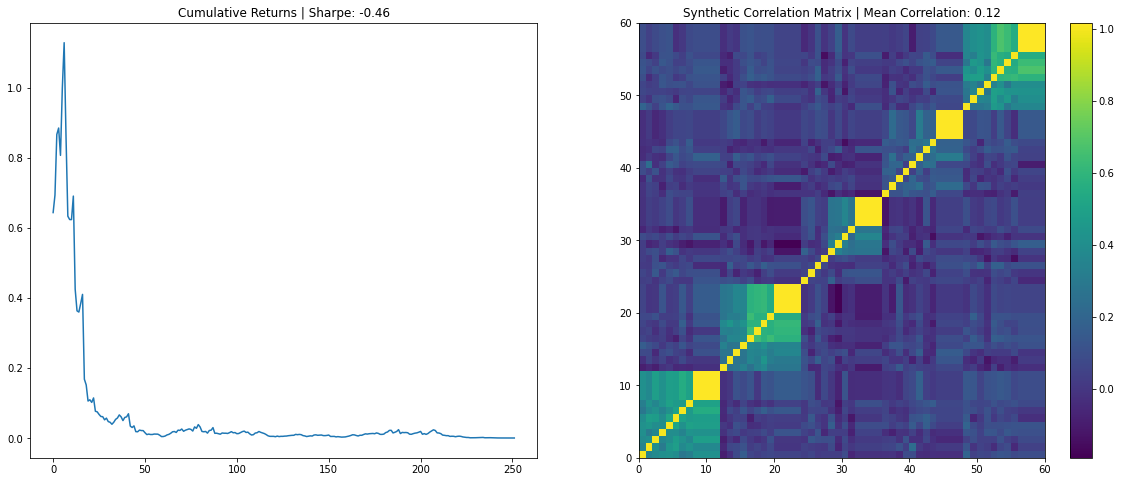

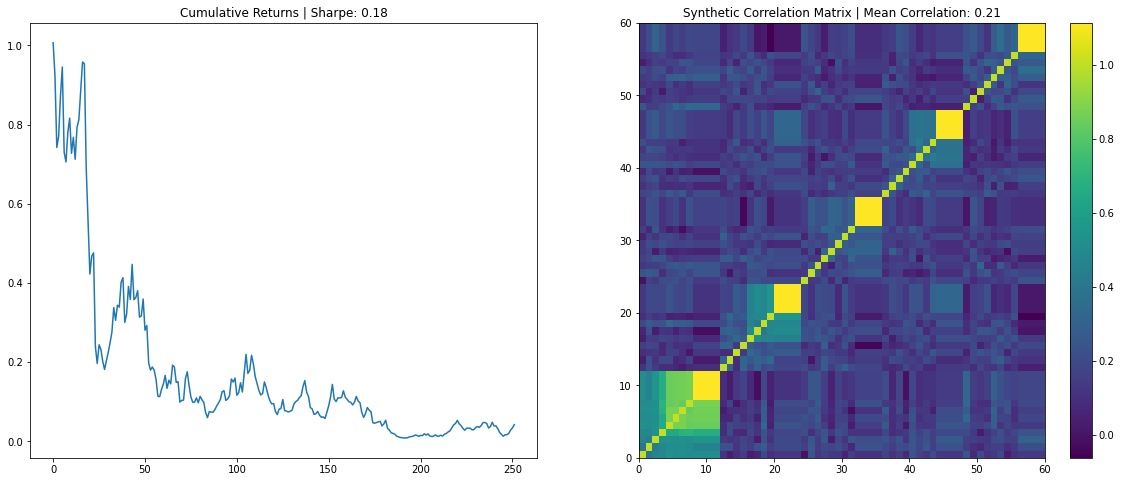

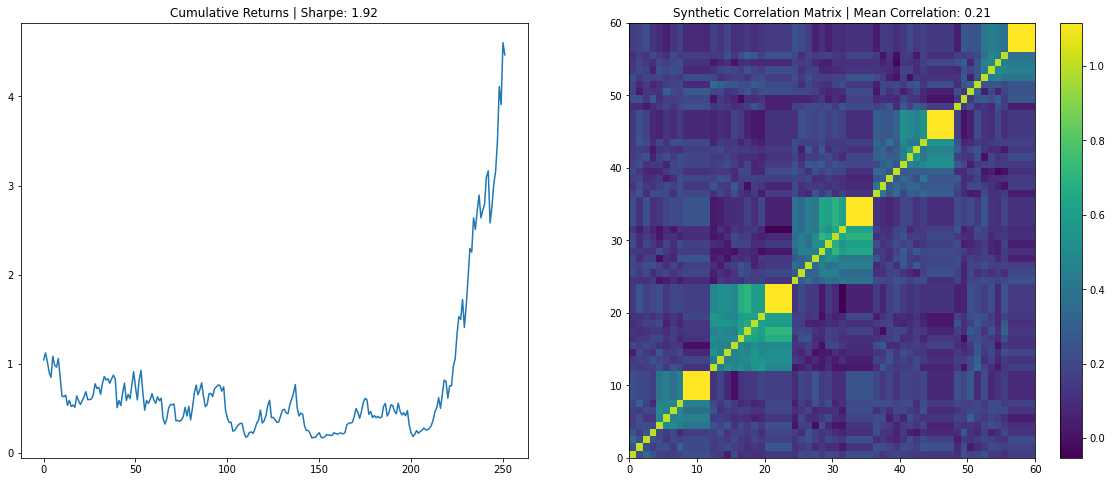

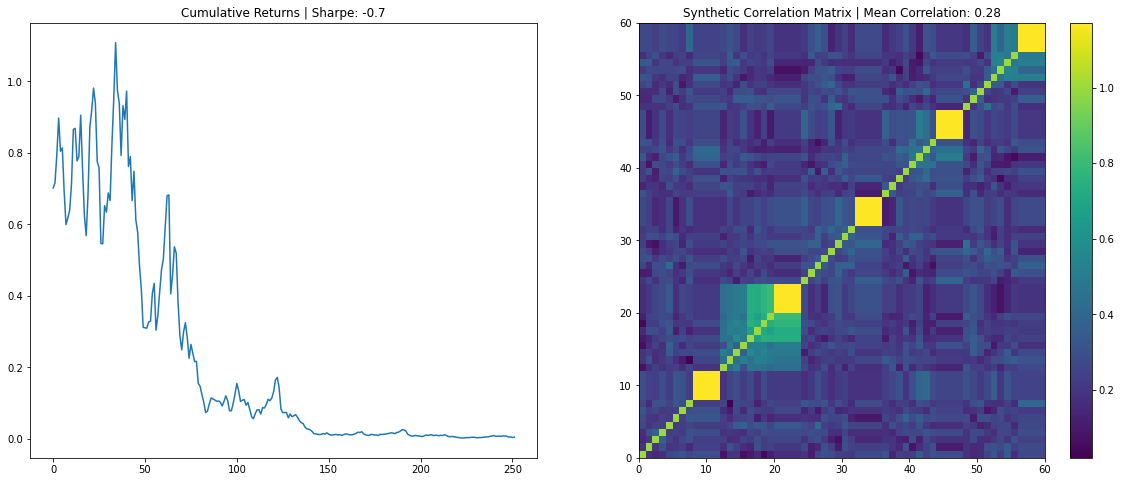

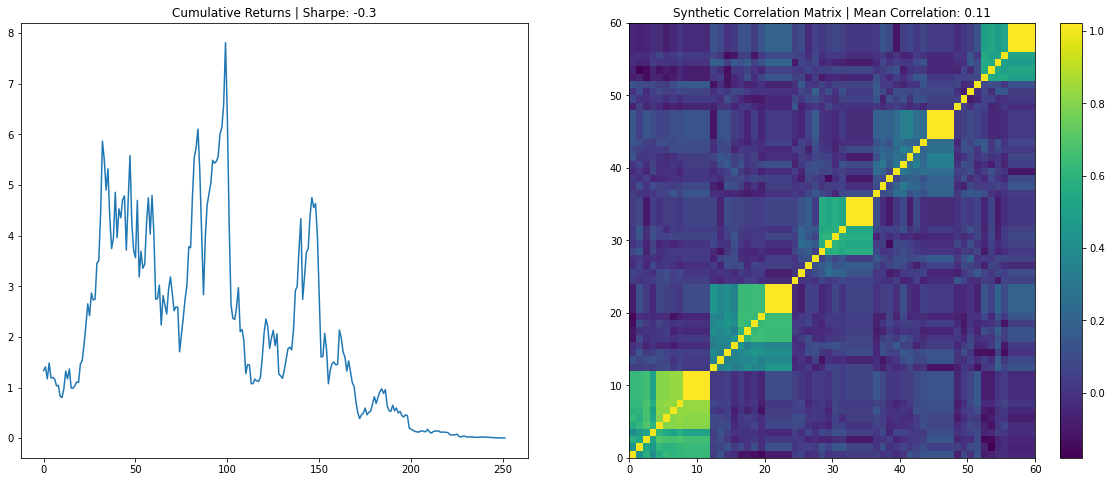

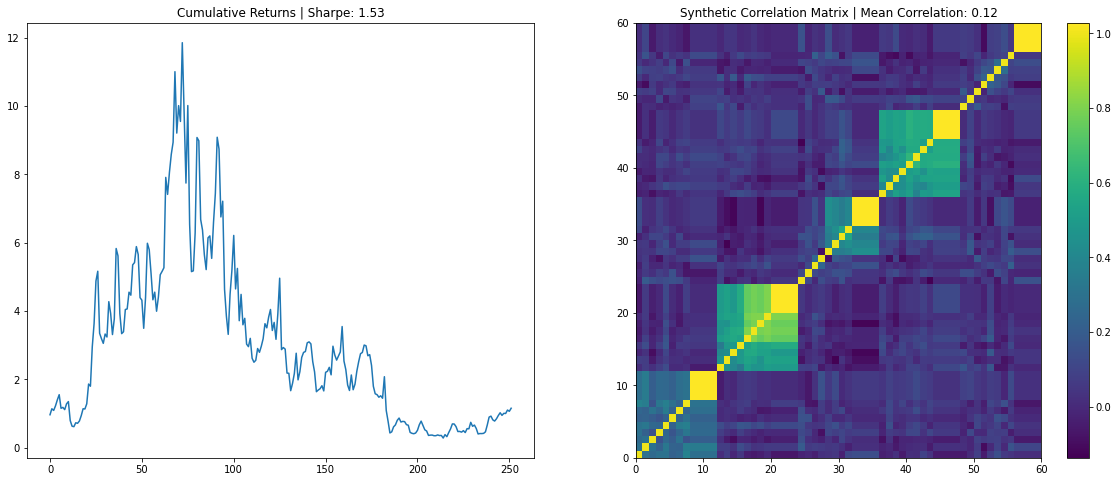

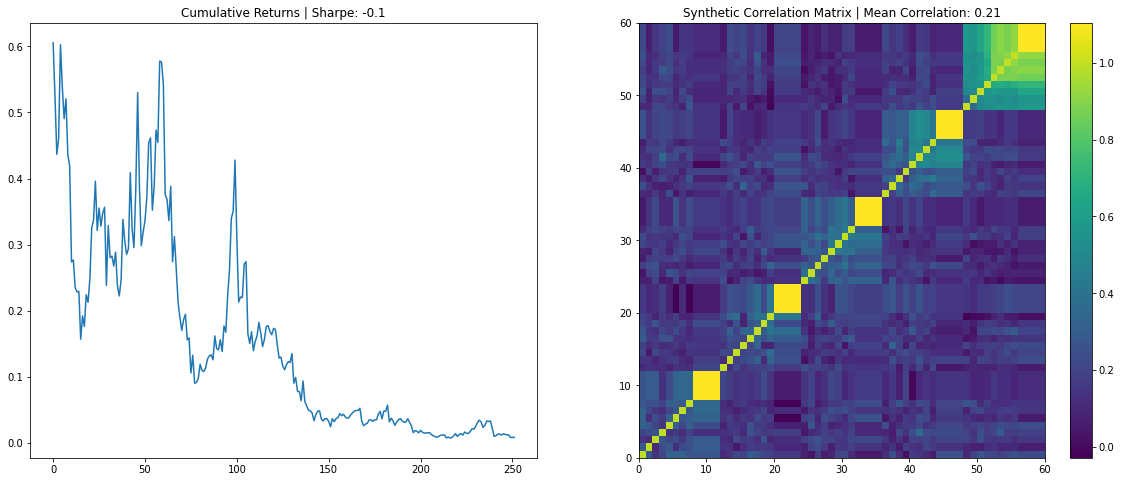

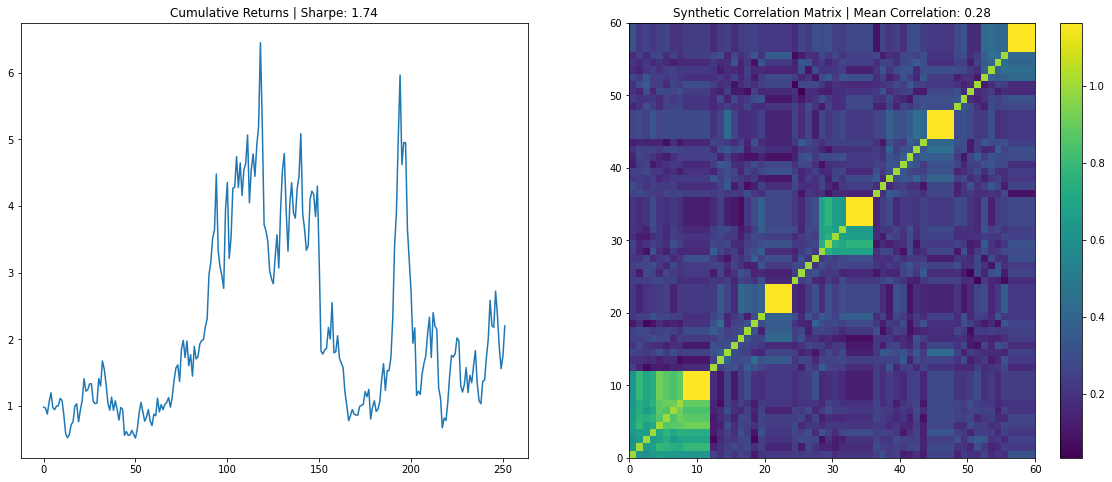

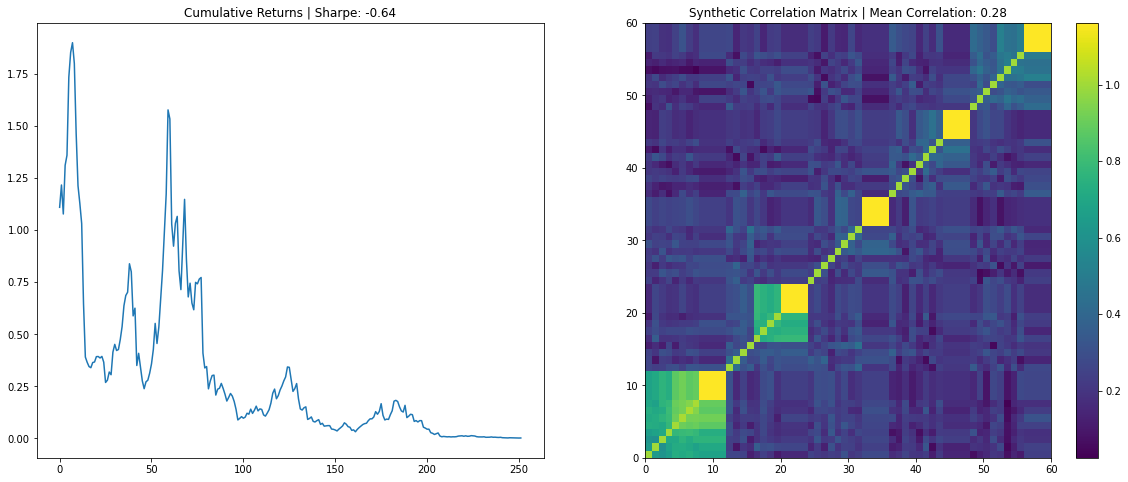

Stressed count: 6000, Rally count: 6000, Normal count: 6000


In [4]:
# Define constants for the hierarchical factor model
N = 60  # Number of assets
c = 3    # Number of clusters
L = 252  # Number of time points
M = 5   # Number of hierarchies

# Directory names
dir_names = ['stressed_mats_synth', 'rally_mats_synth', 'normal_mats_synth']

# Create directories
for dir_name in dir_names:
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)

# Initialize counts and storage
corr_vs_sharpe = []
stressed_mats = []
stressed_count = 0
rally_mats = []
rally_count = 0
normal_mats = []
normal_count = 0
plot_count = 0

while stressed_count < 6000 or rally_count < 6000 or normal_count < 6000:
    try:
        # Select values for c and M dynamically
        #c, M = select_c_and_M(N)

        # Generate synthetic timeseries and correlation matrix
        timeseries, correlation_matrix_model = hierarchical_factor_model(N, c, L, M)
        
        # Randomly choose a target mean for this iteration
        target_mean = np.random.choice(targets)

        # Introduce perturbation to the correlation matrix
        correlation_matrix = adjust_matrix_to_target_mean(correlation_matrix_model, target_mean)

        #timeseries = generate_timeseries_from_correlation(correlation_matrix, L)

        # Calculate Sharpe ratio
        sharpe_ratio = calculate_sharpe_ratio(timeseries.mean(axis=0))
        
        corr_vs_sharpe.append([correlation_matrix.mean(), sharpe_ratio])

        mean_correlation = correlation_matrix.mean()
        #print(mean_correlation)
    
        plot_flag = False
    
        if sharpe_ratio < -0.5 and stressed_count < 6000:
            # Check if mean correlation is within the target mean following a normal distribution with given variance
            if np.abs(mean_correlation - mean_correlations['stressed']) <= 3*np.sqrt(variances['stressed']):
                stressed_mats.append(correlation_matrix)
                np.save(f'{dir_names[0]}/mat_{stressed_count}.npy', correlation_matrix)
                stressed_count += 1
                plot_flag = True
        elif sharpe_ratio > 2 and rally_count < 6000:
            # Check if mean correlation is within the target mean following a normal distribution with given variance
            if np.abs(mean_correlation - mean_correlations['rally']) <= 3*np.sqrt(variances['rally']):
                rally_mats.append(correlation_matrix)
                np.save(f'{dir_names[1]}/mat_{rally_count}.npy', correlation_matrix)
                rally_count += 1
                plot_flag = True
        elif -0.5 <= sharpe_ratio <= 2 and normal_count < 6000:
            # Check if mean correlation is within the target mean following a normal distribution with given variance
            if np.abs(mean_correlation - mean_correlations['normal']) <= 3*np.sqrt(variances['normal']):
                normal_mats.append(correlation_matrix)
                np.save(f'{dir_names[2]}/mat_{normal_count}.npy', correlation_matrix)
                normal_count += 1
                plot_flag = True
        else:
            plot_flag = False

        # Optional: Plotting (if needed)
        if plot_flag and plot_count < 10:
            # Plotting the cumulative returns and correlation matrix
            plt.figure(figsize=(20, 8))

            # Plotting cumulative returns
            plt.subplot(1, 2, 1)
            plt.plot((1 + timeseries.mean(axis=0)).cumprod())
            plt.title(f"Cumulative Returns | Sharpe: {np.round(sharpe_ratio, 2)}")

            # Plotting correlation matrix
            plt.subplot(1, 2, 2)
            plt.pcolormesh(correlation_matrix)
            plt.colorbar()
            plt.title(f"Synthetic Correlation Matrix | Mean Correlation: {np.round(np.nanmean(correlation_matrix), 2)}")
            plt.show()
            plot_count += 1

    except Exception as e:
        print(f"Error: {e}")

# Print the counts
print(f"Stressed count: {stressed_count}, Rally count: {rally_count}, Normal count: {normal_count}")


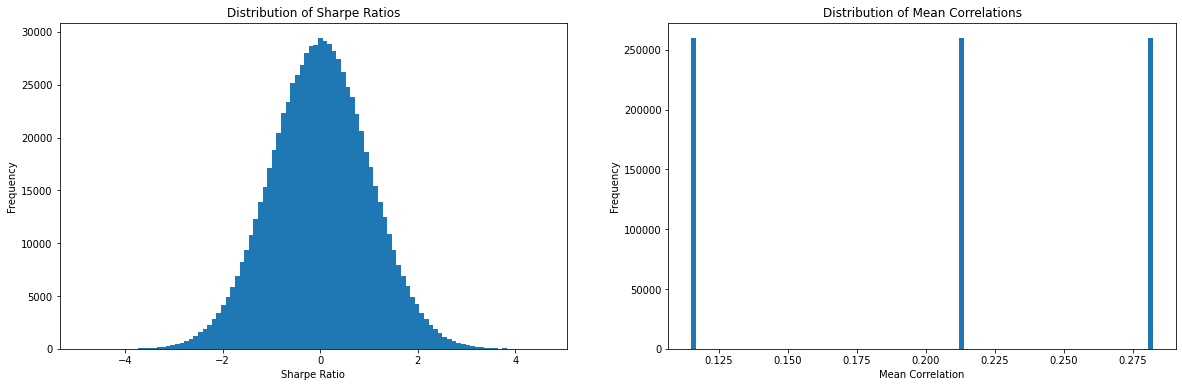

In [5]:
def plot_distributions(corr_vs_sharpe, stressed_mats, rally_mats, normal_mats):
    # Extract and calculate the mean of mean correlations
    mean_correlations = [np.mean(item[0]) for item in corr_vs_sharpe if len(item) > 1]
    sharpe_ratios = [item[1] for item in corr_vs_sharpe if len(item) > 1]

    # Plot distribution of Sharpe Ratios
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.hist(sharpe_ratios, bins=100)
    plt.title('Distribution of Sharpe Ratios')
    plt.xlabel('Sharpe Ratio')
    plt.ylabel('Frequency')

    # Plot distribution of Mean Correlations
    plt.subplot(1, 2, 2)
    plt.hist(mean_correlations, bins=100)
    plt.title('Distribution of Mean Correlations')
    plt.xlabel('Mean Correlation')
    plt.ylabel('Frequency')
    plt.show()

# Usage
plot_distributions(corr_vs_sharpe, stressed_mats, rally_mats, normal_mats)

In [ ]:
def plot_correlation_coefficient_distributions(stressed_mats, rally_mats, normal_mats, tri_a, tri_b):
    # Extract correlation coefficients for each category
    stressed_corr_coeffs = [mat[tri_a, tri_b] for mat in stressed_mats]  
    rally_corr_coeffs = [mat[tri_a, tri_b] for mat in rally_mats]        
    normal_corr_coeffs = [mat[tri_a, tri_b] for mat in normal_mats]      

    # Flatten the lists
    stressed_corr_coeffs = [item for sublist in stressed_corr_coeffs for item in sublist]
    rally_corr_coeffs = [item for sublist in rally_corr_coeffs for item in sublist]
    normal_corr_coeffs = [item for sublist in normal_corr_coeffs for item in sublist]

    # Number of bins
    nbins = 500

    # Plotting distribution of correlation coefficients per category
    plt.figure(figsize=(15, 6))

    plt.hist(normal_corr_coeffs, bins=nbins, alpha=1, label='Normal', density=True, log=False)
    plt.axvline(x=np.mean(normal_corr_coeffs), color='b', linestyle='dashed', linewidth=2)

    plt.hist(stressed_corr_coeffs, bins=nbins, alpha=0.8, label='Stressed', density=True, log=False)
    plt.axvline(x=np.mean(stressed_corr_coeffs), color='r', linestyle='dashed', linewidth=2)

    plt.hist(rally_corr_coeffs, bins=nbins, alpha=0.6, label='Rally', density=True, log=False)
    plt.axvline(x=np.mean(rally_corr_coeffs), color='g', linestyle='dashed', linewidth=2)

    plt.legend()
    plt.title('Distribution of Correlation Coefficients per Category')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Density')
    plt.xlim(left=None, right=1)
    plt.savefig('corr_synth_dist.png', bbox_inches='tight')
    plt.show()

# Usage example (make sure tri_a and tri_b are correctly defined)
dim = 60
tri_a, tri_b = np.triu_indices(dim, k=1)
plot_correlation_coefficient_distributions(stressed_mats, rally_mats, normal_mats, tri_a, tri_b)

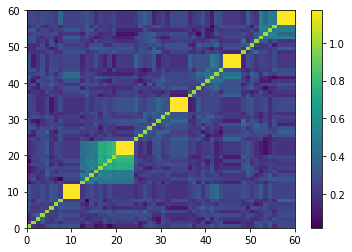

In [7]:
plt.pcolormesh(stressed_mats[0])
plt.colorbar()
#plt.title(f"Ordered Correlation Matrix | Mean Correlation: {np.round(np.nanmean(corr), 2)}")
plt.savefig('stressed_synth_mat.png', bbox_inches='tight')
plt.show()

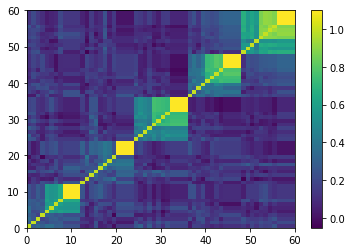

In [8]:
plt.pcolormesh(normal_mats[0])
plt.colorbar()
#plt.title(f"Ordered Correlation Matrix | Mean Correlation: {np.round(np.nanmean(corr), 2)}")
plt.savefig('normal_synth_mat.png', bbox_inches='tight')
plt.show()

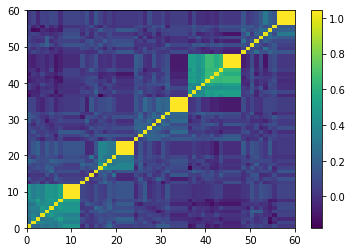

In [9]:
plt.pcolormesh(rally_mats[0])
plt.colorbar()
#plt.title(f"Ordered Correlation Matrix | Mean Correlation: {np.round(np.nanmean(corr), 2)}")
plt.savefig('rally_synth_mat.png', bbox_inches='tight')
plt.show()